## Applied - Question 8

This question involves applying non-linear models to the Auto data set.

#### Import block

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model as skl_lm
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
plt.style.use('seaborn-white')

Importing the data

In [17]:
data_path = 'D:\\PycharmProjects\\ISLR\\data\\'
df = pd.read_csv(f'{data_path}Auto.csv', na_values='?').dropna()

# First look 
df.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


A quick look at the correlation tables show displacement is highly correlated with mpg.

#### Polynomial

A quadratic function of displacement improves our model significantly. Note that cylinders,
weights, and horsepower have a strong correlation with displacement so we skip them here.
However, for a practical model adding them later will improve the accuracy even more.

Notes: A loop will be better to reproduce with more variables

In [18]:
# Set up parameters
kf = KFold(n_splits=10, random_state=1, shuffle=True)
regr = skl_lm.LinearRegression()
MSE_disp = []
MSE_year = []

# Loop through to find the best degree
for i in range(1, 6):
    # Transform polynomial features
    poly = PolynomialFeatures(degree=i)
    
    # Transform X
    X_poly_disp = poly.fit_transform(df.displacement.values.reshape(-1,1))
    X_poly_year = poly.fit_transform(df.year.values.reshape(-1,1))
    
    # record MSE for displacement
    regr.fit(X_poly_disp, df.mpg.ravel())
    score = cross_val_score(regr, X_poly_disp, df.mpg, cv=kf,
                            scoring='neg_mean_squared_error').mean()
    MSE_disp.append(-score)
    
    # record MSE for year
    regr.fit(X_poly_year, df.mpg.ravel())
    score = cross_val_score(regr, X_poly_year, df.mpg, cv=kf,
                            scoring='neg_mean_squared_error').mean()
    MSE_year.append(-score)

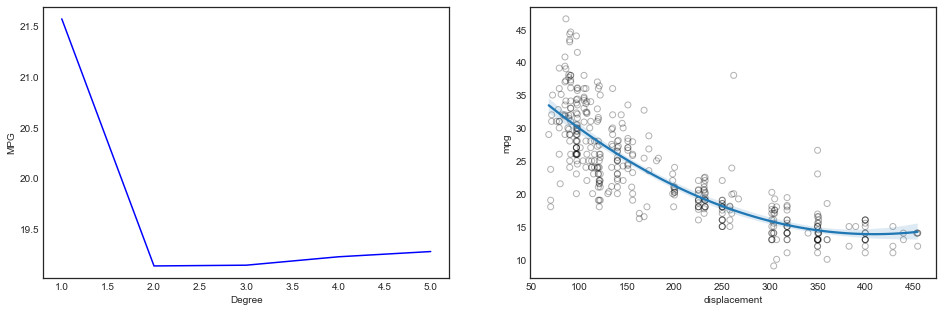

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

# Left plot
sns.lineplot(range(1, 6), MSE_disp, color='b', ax=ax1)
ax1.set_xlabel('Degree')
ax1.set_ylabel('MPG')

# Right plot
ax2.scatter(df.displacement, df.mpg, facecolor='None', edgecolors='k', alpha=0.3)
sns.regplot(df.displacement, df.mpg, order=2, truncate=True, scatter=False, ax=ax2)

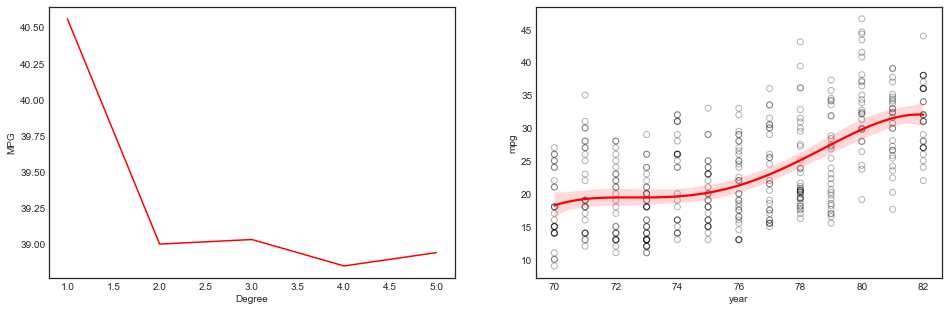

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

# Left plot
sns.lineplot(range(1, 6), MSE_year, color='r', ax=ax1)
ax1.set_xlabel('Degree')
ax1.set_ylabel('MPG')

# Right plot
ax2.scatter(df.year, df.mpg, facecolor='None', edgecolors='k', alpha=0.3)
sns.regplot(df.year, df.mpg, order=4, truncate=True, scatter=False, ax=ax2, color='r')

We see a major improvement using polynomial of degree 2 and 4 for displacement and year
respectively.

#### Step functions

Cutting displacement into brackets and finding optimal number of brackets. The optimal 
given by 10-fold is 9. 

In [40]:
MSE = []

for i in range(2, 15):
    # Cut data into bins
    df_cut = pd.cut(df.displacement, bins=i, right=True)
    
    # Get the step dataframes
    df_steps = pd.concat([df_cut, df.mpg], keys=['disp_cut', 'mpg'], axis=1)
    
    # Transform step dataframe into dummies
    df_steps_dummy = pd.get_dummies(df_steps['disp_cut'])
    df_steps_dummy.values.reshape(-1,1)
    
    # Calculate MSE with 10-fold
    regr = skl_lm.LinearRegression()
    score = cross_val_score(regr, df_steps_dummy, df_steps.mpg, 
                            cv=kf, scoring='neg_mean_squared_error').mean()
    MSE.append(-score)


In [41]:
# Cut data into bins of age
df_cut, bins = pd.cut(df.displacement, bins=9, retbins=True, right=True)
    
# Get the step dataframes
df_steps = pd.concat([df_cut, df.mpg], keys=['disp_cut', 'mpg'], axis=1)

# Transform step dataframe into dummies
df_steps_dummy = pd.get_dummies(df_steps['disp_cut'])
df_steps_dummy.values.reshape(-1,1)

# Get age_grid
disp_grid = np.arange(df.displacement.min(), df.displacement.max()).reshape(-1,1)

# Fit linear regression with 8 bins
bin_mapping = np.digitize(disp_grid.ravel(), bins)
X_test = pd.get_dummies(bin_mapping)
regr = skl_lm.LinearRegression().fit(df_steps_dummy, df_steps.mpg)
y_pred = regr.predict(X_test)

(0, 48.480000000000004)

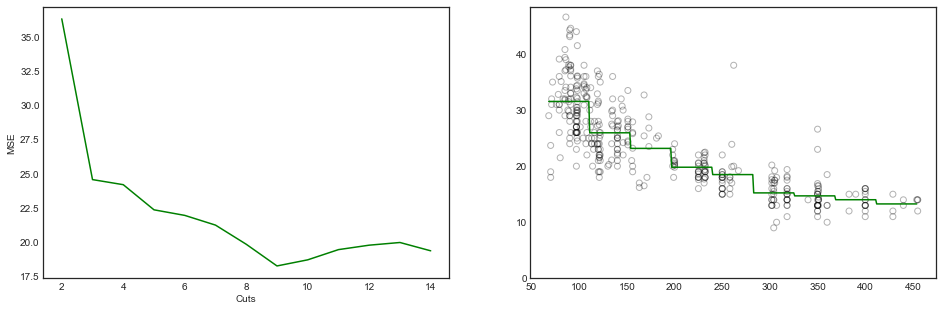

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

# Left plot
ax1.plot(range(2,15), MSE, color='g')
ax1.set_xlabel('Cuts')
ax1.set_ylabel('MSE')

# Plot
ax2.scatter(df.displacement, df.mpg, facecolor='None', edgecolors='k', alpha=0.3)
ax2.plot(disp_grid, y_pred, color='g')
ax2.set_ylim(ymin=0)
ax2.set_xlabel('displacement')
ax2.set_ylabel('MPG')

Finally, lets combine displacement and year into one GAM model

#### GAMs

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


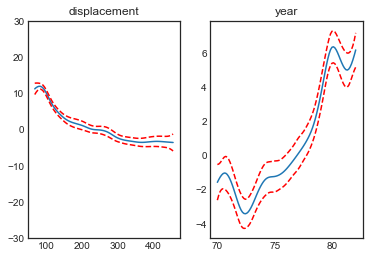

In [42]:
from pygam import LinearGAM, s

df_gam = df[['displacement', 'year']]
gam = LinearGAM(s(0) + s(1))
gam.gridsearch(np.array(df_gam), np.array(df.mpg))

fig, axs = plt.subplots(1,2)

titles = ['displacement', 'year']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

The fancier/more flexible methods fit our data a bit more. In fact, GAMs provides some of
the best fit of Auto dataset. However, I also see a big compromise in time and effort 
to interpret these results. 

Perhaps the simpler methods (like fitting polynomial) maybe better practically!